# Robust Facility Location

Consider the Facility Location Problem (FLP) that focuses on finding the best locations for facilities such as warehouses, plants, or distribution centers to minimize costs and maximize service coverage. It involves deciding where to place these facilities to effectively meet customer demands, while accounting for factors like transportation costs, facility setup costs, and capacity constraints. The goal is to determine the optimal facility locations that efficiently serve demands and maximize overall profits. The approach defined in this notebook aims to maximize profits under the condition of uncertain demand, making this a robust optimization problem.

Taking the example in [1, Section 2.4], let $ T, F, N$ be the length of the horizon, the number of candidate locations to which a facility can be assigned and the number of locations that have a demand for the facility respectively.

- $\eta \in {\bf R}$ denotes the unit price of goods 
- $c, c^{\rm stor} ,c^{\rm open} \in {\bf R}^{F}$ denotes the cost per unit of production, cost per unit capacity and the cost of opening a facility at all locations
- ${c^{\rm ship}} \in {\bf R}^{F\times N}$ denotes the cost of shipping from one location to another
- ${d^{\rm u}_t} \in {\bf R}^{N}$ denotes the uncertain demand for period $t$ at location
- $X_t \in {\bf R}^{F\times N}$ denotes the proportion of the demand at a location during period $t$ that is satisfied by a facility
- $p_t\in {\bf R}^{F}$ denotes the amount of goods that is produced at some facility at a time period $t$
- $y$ denotes whether a facility at a location is open or closed, by taking values 1 or 0, respectively
- ${z}$ denotes the capacity of the facility in this location in case it is open
- $d^*$ denotes the demand for a period in the deterministic case
 
 Let $M > 0$ be a large constant.


$$
\begin{array}{ll}
\text{maximize} & \theta \\
\text{subject to} & \sum_{\tau = 1}^T \sum_{i = 1}^F \sum_{j = 1}^N (\eta - c^{\rm ship}_{ij}) X_{ij\tau} d^{u}_{i\tau} - \sum_{\tau = 1}^T \sum_{i = 1}^F c_i p_{i\tau} - \sum_{i = 1}^F c^{\rm stor}_i z_i - \sum_{i = 1}^F c^{\rm open}_i y_i \\
                & \sum_{i = 1}^F X_{ij\tau} \leq 1, \\
                & \sum_{j = 1}^N X_{ij\tau} d^{\rm u}_{j\tau} \leq P_{i\tau} \quad d^{\rm u} \in \mathcal{U}\\
                & X \ge 0 \\
                & p_t \leq {z} \quad t =1,\dots,T \\
                & {z} \leq My \\
                & y \in \{0, 1\}^F
\end{array}
$$

We solve this problem using the ellipsoidal uncertainty set, formulated by: 

$$ \mathcal{U}_{\text{ellips}} = \{z+d^* \ | \ \| z\|_2 \le \rho\} $$



In [1]:
import numpy as np 
import cvxpy as cp 
import lropt
import networkx as nx
import matplotlib.pyplot as plt

In the following snippet, we generate data. This example has $5$ facilities and $8$ candidate locations. The length of each horizon is $10$ and the unit price of each good is $100$.

In [2]:
np.random.seed(1)
T = 10 
F = 5   
N = 8  
M = 1100
ETA = 100.0 
RHO = 0.3

c = np.random.rand(F)
c_stor = np.random.rand(F)
c_open = np.random.rand(F)
c_ship = np.random.rand(F, N)
d_star = np.random.rand(N*T) 


x = {}
for i in range(F):
    x[i] = cp.Variable((N, T))
    

d_u = lropt.UncertainParameter(N*T, uncertainty_set = lropt.Ellipsoidal(b = d_star, rho = RHO)) #Flattened Uncertain Parameter - LROPT only supports one dimensional uncertain parameters
p = cp.Variable((F, T))
z = cp.Variable(F)
y = cp.Variable(F, boolean=True)
theta = cp.Variable()

Next, we define all our constraints

In [3]:
revenue = cp.sum([((ETA - np.diag(c_ship[i])) @ x[i]).flatten() @ d_u for i in range(F)])
cost_production = cp.sum(c @ p)
fixed_costs = c_stor@z
penalties = c_open@y

constraints = [
revenue - cost_production - fixed_costs - penalties >= theta,
z <= M*y,
]

constraints.append(cp.sum([x[i] for i in range(F)]) <= 1)
for i in range(F):
    for t in range(T):
        constraints.append(cp.sum([x[i][j,t] * d_u[j*T + t] for j in range(N)]) <=p[i, t])

for i in range(F):
    constraints.append(x[i]>=0)

for t in range(T):
    constraints.append(p.T[t]<=z)
constraints += [p>=0]

/Users/irina.wang/Desktop/Princeton/Project2/lropt/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:498: FutureWarning: 
    You didn't specify the order of the flatten expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(flatten_order_warning, FutureWarning)


Finally, we define the objective and get the optimal value for the equation. 

In [6]:
objective = cp.Maximize(theta)
prob = lropt.RobustProblem(objective, constraints)
prob.solve(solver = cp.SCIP)

In [7]:
print(f"The robust optimal value using  is {theta.value:.3E}")

The robust optimal value using  is 3.109E+04


To compare the solution of the problem without an uncertainty parameter, the following code solves the problem in the deterministic case. 

In [9]:
np.random.seed(1)
T = 10 
F = 5   
N = 8  
M = 1100
ETA = 100.0 
RHO = 0.3

c = np.random.rand(F)
c_stor = np.random.rand(F)
c_open = np.random.rand(F)
c_ship = np.random.rand(F, N) #Cost of shipping from one location to another
d_star = np.random.rand(N*T)  # Deterministic demand

d_u = lropt.UncertainParameter(N*T, uncertainty_set = lropt.Ellipsoidal(b = d_star, rho = RHO)) #Flattened Uncertain Parameter - LROPT only supports one dimensional uncertain parameters
p = cp.Variable((F, T))
z = cp.Variable(F)
y = cp.Variable(F, boolean=True)

x_det = {}
for i in range(F):
    x_det[i] = cp.Variable((N, T))
theta = cp.Variable()


revenue = cp.sum([((ETA - np.diag(c_ship[i])) @ x_det[i]).flatten() @ d_star for i in range(F)])
cost_production = cp.sum(c@ p)
fixed_costs = c_stor@z
penalties = c_open@y

constraints = [
revenue - cost_production - fixed_costs - penalties >= theta,
z <= M*y,
]

constraints.append(cp.sum([x_det[i] for i in range(F)]) <= 1)
for i in range(F):
    for t in range(T):
        constraints.append(cp.sum([x_det[i][j,t] * d_star[j*T + t] for j in range(N)]) <=p[i, t])

for i in range(F):
    constraints.append(x_det[i]>=0)

for t in range(T):
    constraints.append(p.T[t]<=z)
constraints += [p>=0]

objective = cp.Maximize(theta)
prob = lropt.RobustProblem(objective, constraints)
prob.solve(solver = cp.SCIP)


/Users/irina.wang/Desktop/Princeton/Project2/lropt/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:498: FutureWarning: 
    You didn't specify the order of the flatten expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(flatten_order_warning, FutureWarning)


In [7]:
print(f"The deterministic optimal value using  is {theta.value:.3E}")

The deterministic optimal value using  is 3.323E+04


This is a facility - network graph created using the robust optimal value of $x$.

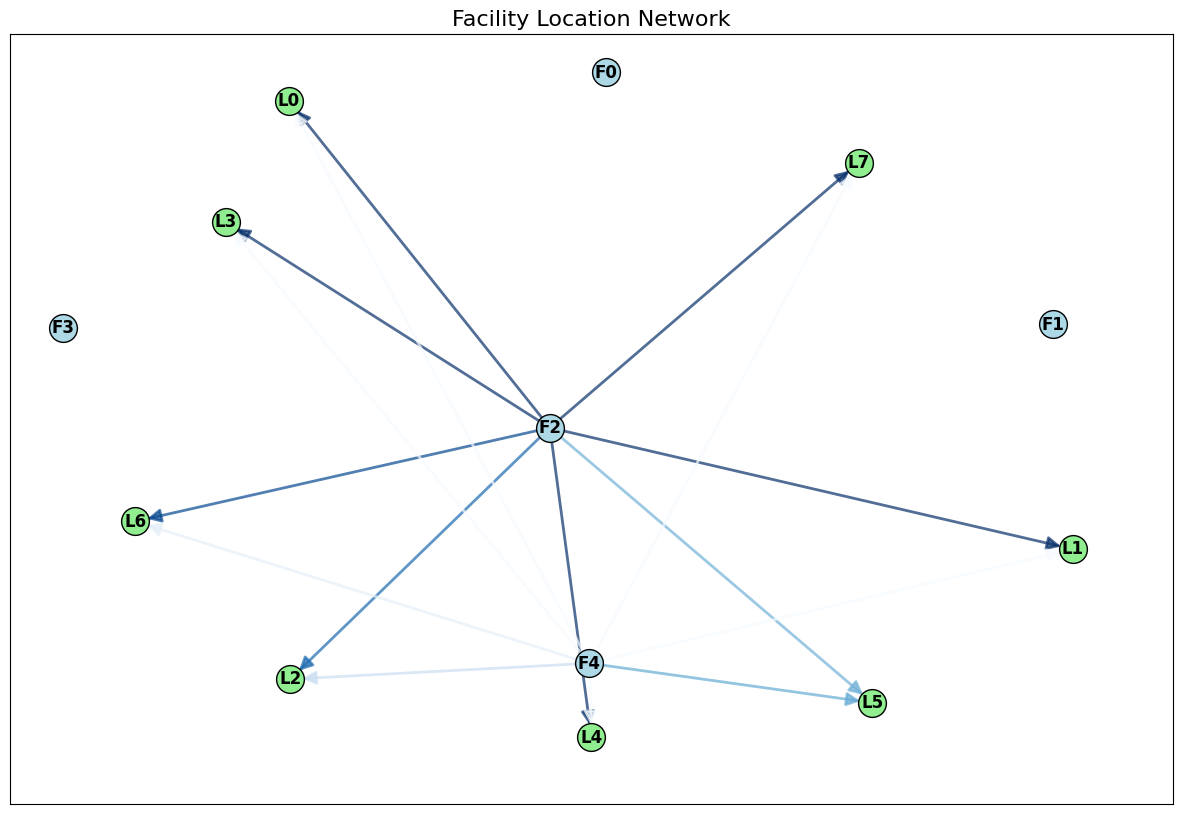

In [10]:
x_opt = np.hstack([v.value.flatten() for v in x.values()]).reshape((F * T, N))

G = nx.DiGraph()


facility_nodes = range(F)
location_nodes = range(F, F + N)


G.add_nodes_from(facility_nodes, bipartite=0)
G.add_nodes_from(location_nodes, bipartite=1)


for i in range(F):
    for j in range(N):
        if x_opt[i * T, j] > 0:
            G.add_edge(i, F + j, weight=x_opt[i * T, j])


pos = nx.spring_layout(G, seed=42) 
fig, ax = plt.subplots(figsize=(15, 10))
nx.draw_networkx_nodes(G, pos, nodelist=facility_nodes, node_color='lightblue', node_size=400, edgecolors='k', node_shape='o')
nx.draw_networkx_nodes(G, pos, nodelist=location_nodes, node_color='lightgreen', node_size=400, edgecolors='k', node_shape='o')


edges = G.edges(data=True)
edge_weights = [data['weight'] for u, v, data in edges]


edge_weights = np.array(edge_weights)
edge_colors = edge_weights


nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, alpha=0.7, edge_color=edge_colors, edge_cmap=plt.cm.Blues, arrows=True, arrowsize=20)
nx.draw_networkx_labels(G, pos, labels={i: f"F{i}" for i in facility_nodes}, font_size=12, font_weight='bold', verticalalignment='center')
nx.draw_networkx_labels(G, pos, labels={F + j: f"L{j}" for j in range(N)}, font_size=12, font_weight='bold', verticalalignment='center')
plt.rcParams.update({"font.size": 18})
plt.title('Facility Location Network', fontsize=16)
plt.show()

## References

1. Bertsimas, Dimitris, and Dick Den Hertog. Robust and Adaptive Optimization. [Dynamic Ideas LLC], 2022.